# Capstone Project 1
# Lending Club Loan Status Analysis
## Part 2: Data Storytelling with Engineered Features

Data Source: Kaggle Dataset -- Lending Club Loan Data  
URL: https://www.kaggle.com/wendykan/lending-club-loan-data  
Analyst: Eugene Wen

### Introduction
Through Part 1, we raised up a few interesting questions in this dataset. They are:
1. How is the LendingClub total loan amount change over time? How about volume (number of approved loans)?
2. Whether the loan amount and volume has geographic pattern?
3. How many categories does loan status have? How are they distributed?
4. The loan grade is expected to reflect the risk. Is this true?
5. How are these loan used for? 

In this part of analysis we will address these questions, regardless their relevance to the loan status.

In [1]:
# Load the cleaned dataset from Part 1
%run ./py/DataWrangling.py

In [2]:
# Load used python modules and functions
import pandas as pd
import numpy as np
import plotly.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.layouts import row, column

#### Question 1: How is the LendingClub total loan amount change over time? How about volume (number of approved loans)?

Both the total loan amount and the loan volume show exponentially growth trends, and starting from the year 2014 there are some (seasonal) fluctuations. In general this is a good indication for a start-up business because the transactions increase over years and the business is growing.

In [3]:
# Plot founded_amnt_inv vs 
#loan.sort(axis=1, inplace=True)
#loan.info()
# First, aggregate founded_amount by year and month
loan_by_month_amnt = loan[["issue_d","funded_amnt"]].groupby("issue_d", as_index=False).sum()
loan_by_month_vol  = loan[["issue_d","funded_amnt"]].groupby("issue_d", as_index=False).count()

# Plot time series of both amount and volume
x = loan_by_month_amnt["issue_d"]
y_amnt = loan_by_month_amnt["funded_amnt"]
y_vol = loan_by_month_vol["funded_amnt"]

p1 = figure(title="Funded Loan Amount over Years", x_axis_label="Time", y_axis_label="Loan in US$", x_axis_type='datetime')
p1.line(x, y_amnt, line_width=2)

p2 = figure(title="Funded Loan Volume over Years", x_axis_label="Time", y_axis_label="Number of Loans Funded", x_axis_type='datetime')
p2.line(x, y_vol, line_width=2)

layout = column(p1, p2)
output_notebook()
show(layout)

Loading BokehJS ...

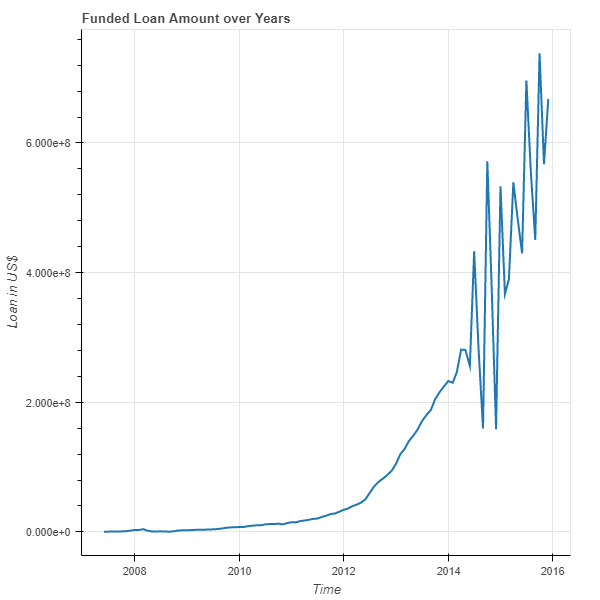

In [4]:
# Alternatively, insert the two bokeh images:
from IPython.display import Image
Image("./img/bokeh1.png")

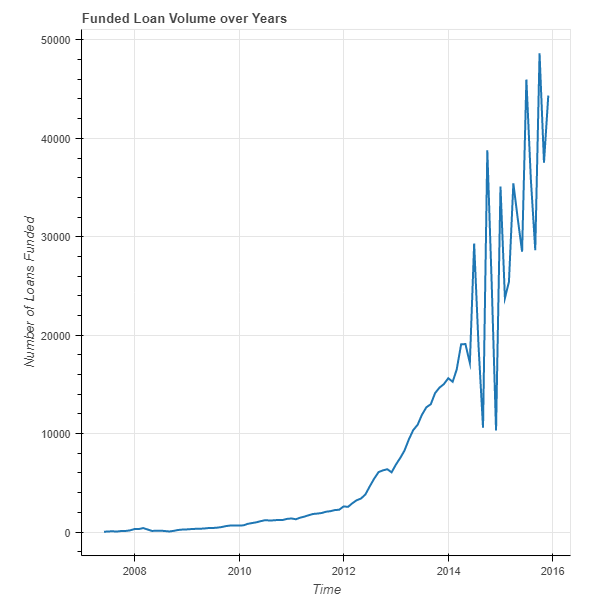

In [5]:
Image("./img/bokeh2.png")

#### 2.Whether the loan amount and volume has geographic pattern?

The loan amount and volume both show strong geographic pattern. By simply ranking the loan amount and loan volume, we see the top 10 States are the same with slightly change on ranking. California has the highest total loan amount as well as the volume.

In [6]:
# Aggregate funded_amnt by state
loan_by_state_amnt = loan[["addr_state","funded_amnt"]].groupby("addr_state", as_index=False).sum()
loan_by_state_vol  = loan[["addr_state","funded_amnt"]].groupby("addr_state", as_index=False).count()

# Plot time series of both amount and volume
x = loan_by_state_amnt["addr_state"]
y_amnt = loan_by_state_amnt["funded_amnt"]
y_vol = loan_by_state_vol["funded_amnt"]

# Save the two DataFrames for mapping in R
loan_by_state_amnt.to_csv("./img/loan_by_state_amount.csv", index=False)
loan_by_state_vol.to_csv("./img/loan_by_state_volume.csv", index=False)

   addr_state   funded_amnt
4          CA  1.896017e+09
43         TX  1.108151e+09
34         NY  1.075829e+09
9          FL  8.480154e+08
14         IL  5.386763e+08
31         NJ  5.145831e+08
38         PA  4.552488e+08
10         GA  4.342597e+08
35         OH  4.224189e+08
45         VA  4.108803e+08


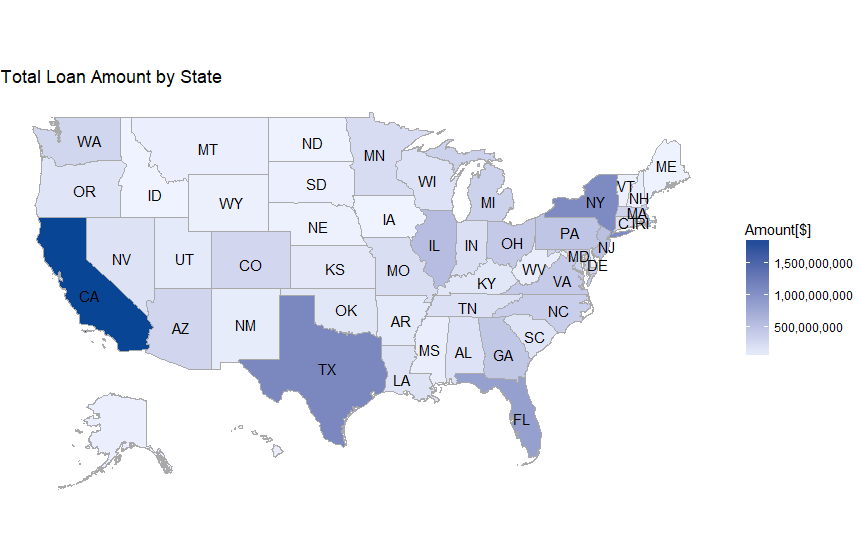

In [7]:
print(loan_by_state_amnt.sort_values(by="funded_amnt",ascending=False).head(10))
Image("./img/Amount_map.png")

   addr_state  funded_amnt
4          CA       129517
34         NY        74086
43         TX        71138
9          FL        60935
14         IL        35476
31         NJ        33256
38         PA        31393
35         OH        29631
10         GA        29085
45         VA        26255


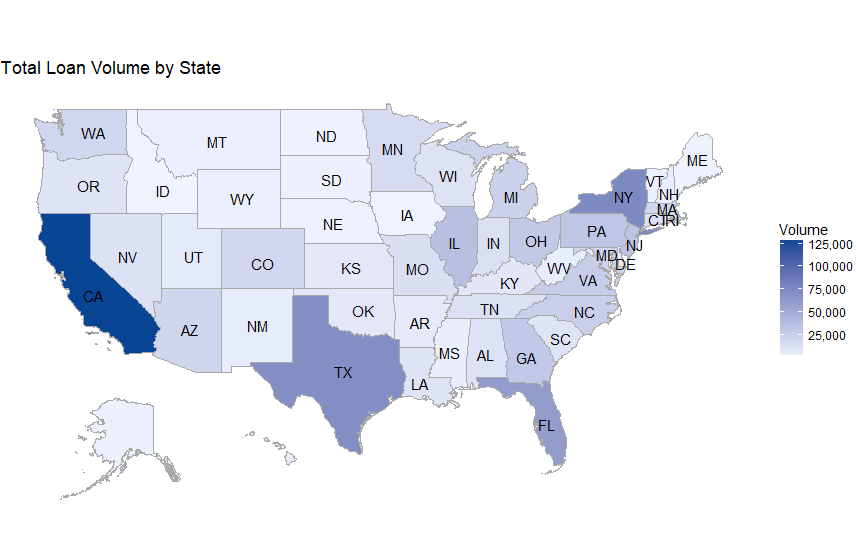

In [8]:
print(loan_by_state_vol.sort_values(by="funded_amnt", ascending=False).head(10))
Image("./img/Volume_map.png")

#### 3.How many categories does loan status have? How are they distributed?

There are 10 categories of loan status as recorded by LendingClub, but there are some ambiguity such as "Does not meet the credit policy...", and the category selection causes fragmental distribution. It would make more sense to consolidate some of these categories. As a straightforward way, Current and Fully Paid should be good indicators, Issued should mean the loan is just issued but no more information, and others are all bad indicators because they are leading to the risk of being default.

The loan_status variable was mapped to the three new categories above: Good, Bad, and Issued. In total we have 67429 bad loans, 
811490 good loans, and 8460 newly issued loans. The overall bad loan rate is 7.6%. The distribution is highly unbalanced!

In [9]:
# Check loan_status
loan.groupby("loan_status").size().sort_values()

loan_status
Does not meet the credit policy. Status:Charged Off       761
Default                                                  1219
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        2357
In Grace Period                                          6253
Issued                                                   8460
Late (31-120 days)                                      11591
Charged Off                                             45248
Fully Paid                                             207723
Current                                                601779
dtype: int64

In [10]:
# Recode the status to form a simpler status variable named loan_status_simple
# Good (0): Current, Fully Paid
# Bad (1):  Default, Late (all types), In Grace Period, Charge Off
# Issued: leave blank for scoring

loan_dict = {
    "Does not meet the credit policy. Status:Charged Off": "Bad",
    "Default": "Bad",
    "Does not meet the credit policy. Status:Fully Paid": "Good",
    "Late (16-30 days)": "Bad",
    "In Grace Period": "Bad",
    "Issued": "Issued",
    "Late (31-120 days)":"Bad",
    "Charged Off":"Bad",
    "Fully Paid": "Good",
    "Current": "Good"
}
loan["loan_status_simple"] = loan["loan_status"].map(loan_dict)

# Potentially we can use the Good/Bad observations to score the Issued loans and estimate its risk of turning bad.
loan_train = loan.loc[loan["loan_status"] != "Issued", :]
loan_holdout = loan.loc[loan["loan_status"] == "Issued", :]

# Check loan_status
loan.groupby("loan_status_simple").size().sort_values()

loan_status_simple
Issued      8460
Bad        67429
Good      811490
dtype: int64

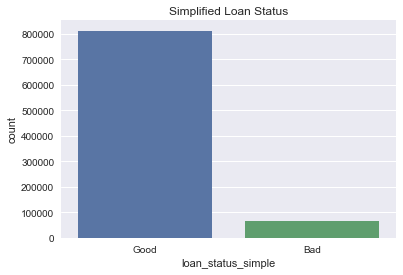

In [11]:
# Plot the newly created loan status variable: loan_status_simple

sns.set()
sns.countplot(loan_train["loan_status_simple"])
plt.title("Simplified Loan Status")
plt.show()

#### 4.The loan grade is expected to reflect the risk. Is this true?

Through the plot and table, we can clearly see that the better the grade, the less the bad loan rate. Grade A has only 2.5% bad rate while Grade G has 23.1%, about 8 times higher! This shows that the grading system used by LendingClub is quite efficient.

In [12]:
# Calculate the percentage of bad loans for each grade
loan_by_grade = loan.groupby("grade", as_index=False).agg({"loan_status_simple": lambda x: np.mean(x == "Bad")})
print(loan_by_grade)

  grade  loan_status_simple
0     A            0.024716
1     B            0.052865
2     C            0.077499
3     D            0.113650
4     E            0.137826
5     F            0.190185
6     G            0.231190


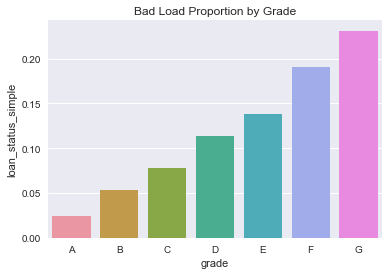

In [13]:
# Plot the result
sns.set()
sns.barplot(x="grade", y="loan_status_simple", data=loan_by_grade)
plt.title("Bad Load Proportion by Grade")
plt.show()

#### 5.How are these loan used for? 

Although this question is not quite related to the loan status, our target for modeling, it would be interesting to know why the borrowers want to get loan, i.e. where did they intend to use the money.

From the results it is pretty clear that the majority usage of loan is for debt consolidation, followed by credit card, which seems also somehow related to debt consolidation. Both categories occupy about 82% of total loans. As nowadays personal finance management course emphasizes, personal debt management is the key to financial stability and freedom. It makes sense the two categories are the major purposes of loan application.

In [14]:
# Calculate the percentage of loan usage defined by Purpose
loan_by_purpose = loan.groupby("purpose", as_index=False).agg({"loan_status_simple": lambda x: len(x)/len(loan)})
loan_by_purpose = loan_by_purpose.sort_values("loan_status_simple", ascending=False)
print(loan_by_purpose)

               purpose  loan_status_simple
2   debt_consolidation            0.590745
1          credit_card            0.232349
4     home_improvement            0.058407
9                other            0.048338
6       major_purchase            0.019470
11      small_business            0.011694
0                  car            0.009988
7              medical            0.009624
8               moving            0.006101
12            vacation            0.005337
5                house            0.004177
13             wedding            0.002645
10    renewable_energy            0.000648
3          educational            0.000477


In [15]:
# Recode the purpose for better display
# Consolidate the groups below 5% into MISC

purpose_dict = {
    "debt_consolidation": "debt_consolidation",
    "credit_card": "credit_card",
    "home_improvement": "home_improvement",
    "other": "MISC",
    "major_purchase": "MISC",
    "small_business": "MISC",
    "car":"MISC",
    "medical":"MISC",
    "moving": "MISC",
    "vacation": "MISC",
    "house": "MISC",
    "wedding": "MISC",
    "renewable_energy": "MISC",
    "educational": "MISC"
}

loan["purpose_simple"] = loan["purpose"].map(purpose_dict)

# Redo loan_by_purpose data above
loan_by_purpose = loan.groupby("purpose_simple", as_index=False).agg({"loan_status_simple": lambda x: len(x)/len(loan)})
loan_by_purpose = loan_by_purpose.sort_values("loan_status_simple", ascending=False)
print(loan_by_purpose)

       purpose_simple  loan_status_simple
2  debt_consolidation            0.590745
1         credit_card            0.232349
0                MISC            0.118498
3    home_improvement            0.058407


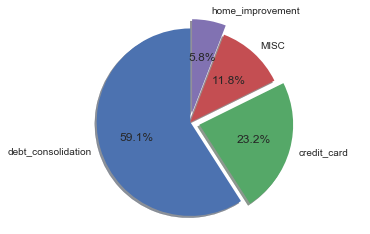

In [16]:
# Make a pie chart for loan_by_purpose
# The slices will be ordered and plotted counter-clockwise
labels = loan_by_purpose["purpose_simple"]
sizes = loan_by_purpose["loan_status_simple"]
explode = (0, 0.1, 0, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [17]:
# Dump the processed loan DataFrame into [tempdata] folder
loan.to_csv("./tempdata/loan_step2.csv", index=False)